In [6]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Wrangling of one file tracking data

The dataset contains 5min of tracking information for each player in a club, recording their precise x and y coordinates.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
import matplotlib.cm as cm
import glob
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Import tracking data from one recording of 5 minutes

In [8]:
data = pd.read_csv("tracking_data.txt", sep=",", header=None)
data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
data.head()

frame_number  track_id  role    xbox   ybox     w     h  xworld  yworld  \
0             0        61     0  1596.2  265.0  62.1  97.6    47.6    48.1   
1             0        62     1  1646.2  146.1  31.3  58.7    47.8    31.9   
2             0        63     0  1590.5  165.0  28.6  61.5    46.3    35.2   
3             0        64     3   855.9  292.0  34.5  51.7    19.3    33.5   
4             0        65     1  1770.2   95.4  19.4  38.7    52.4    13.6   

    IoU  
0  0.00  
1  0.00  
2  0.00  
3  0.00  
4  0.05

`role` feature:
* 0/1 - players
* 2 - ref
* 3/4 - goalies
* -1 - unused detections (non-players and non-refs)
  

`xworld` and `yworld` are in meters measured from the back left corner flag (from the point of view of the camera).

In [9]:
data.shape

(28565, 10)

In [10]:
data["track_id"].nunique()

30

We have 30 unique tracking IDs, representing only the outfield players and referees.

As a result, there may be instances where non-player or non-referee objects are detected, or cases where an object is reassigned or re-identified. This can happen in highly occluded situations (in football these are corners or free kicks, with a large number of players on a small area of the pitch)

In [11]:
data["role"].value_counts()

role
 0    12469
 1    12455
 2     1250
 4     1250
 3     1134
-1        7
Name: count, dtype: int64

In [12]:
data

frame_number  track_id  role    xbox   ybox      w      h  xworld  \
0                 0        61     0  1596.2  265.0   62.1   97.6    47.6   
1                 0        62     1  1646.2  146.1   31.3   58.7    47.8   
2                 0        63     0  1590.5  165.0   28.6   61.5    46.3   
3                 0        64     3   855.9  292.0   34.5   51.7    19.3   
4                 0        65     1  1770.2   95.4   19.4   38.7    52.4   
...             ...       ...   ...     ...    ...    ...    ...     ...   
28560          7494        74     0  2899.2  527.3   50.9   69.1    80.5   
28561          7494        81     0  2192.3  205.4   39.5   61.7    63.9   
28562          7494        77     1  2402.8  229.7   34.9   51.2    74.4   
28563          7494        71     1  2920.7  932.3  125.1  128.9    63.0   
28564          7494        68     2  2911.6  884.8  104.2  145.0    63.1   

       yworld   IoU  
0        48.1  0.00  
1        31.9  0.00  
2        35.2  0.00  
3        33.5  0.00  
4        13.6  0.05  
...       ...   ...  
28560    51.1  0.00  
28561    35.6  0.00  
28562    30.1  0.20  
28563    65.7  0.36  
28564    65.2  0.36  

[28565 rows x 10 columns]

remove the unnecessary columns

In [13]:
data = data.drop( ["xbox", "ybox", "w", "h"], axis=1)

first frame of the clip of team 0 

In [14]:
data[(data["frame_number"] == 0) & (data["role"] == 0)]

frame_number  track_id  role  xworld  yworld   IoU
0              0        61     0    47.6    48.1  0.00
2              0        63     0    46.3    35.2  0.00
8              0        69     0    55.6    36.8  0.01
13             0        74     0    80.3    38.9  0.00
14             0        75     0    62.4    36.4  0.00
15             0        76     0    78.6    53.1  0.00
19             0        80     0    75.7    31.1  0.09
20             0        81     0    71.5    28.7  0.00
22             0        83     0    53.7    18.7  0.00
24             0        85     0    56.8    25.8  0.01

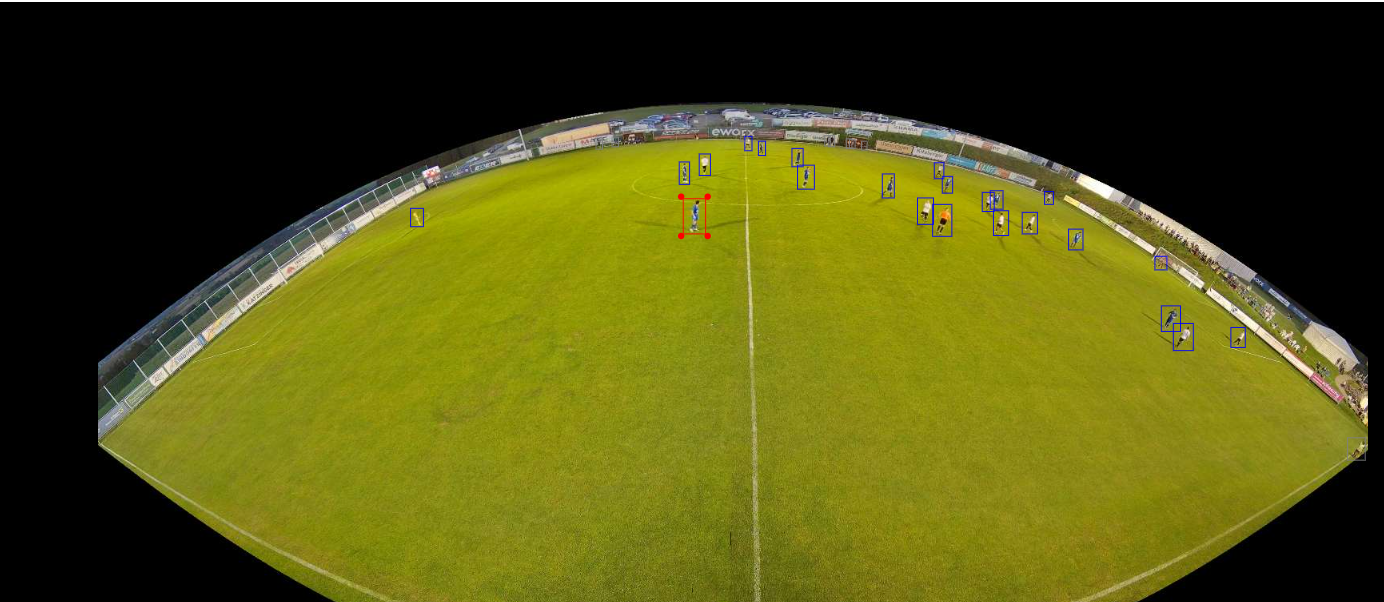

# EDA

In [15]:
data_team0 = data[data["role"] == 0]
data_team0["track_id"].nunique()   

10

plot the first 5min of tracking/runnning data from each player

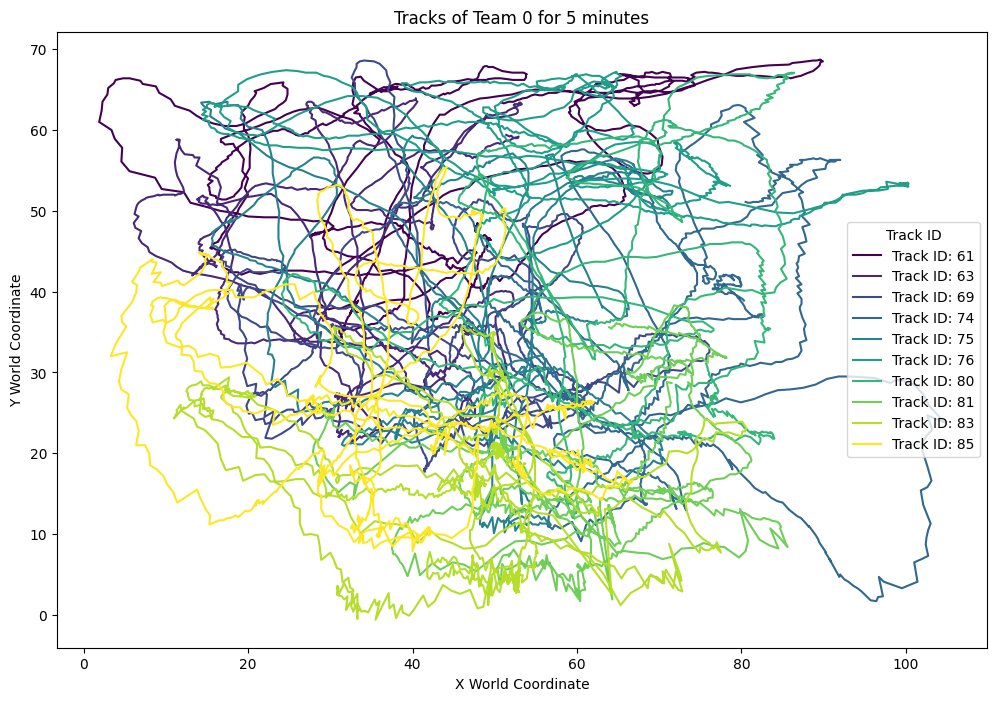

In [16]:
# Get unique track IDs
unique_tracks = data_team0['track_id'].unique()

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_tracks)))
for idx, track_id in enumerate(unique_tracks):
    track_data = data_team0[data_team0['track_id'] == track_id]
    plt.plot(track_data['xworld'], track_data['yworld'], color=colors[idx], linestyle='-', markersize=1, label=f'Track ID: {track_id}')

plt.title('Tracks of Team 0 for 5 minutes')
plt.xlabel('X World Coordinate')
plt.ylabel('Y World Coordinate')
plt.legend(title='Track ID')
plt.show()

In [17]:
data[(data["frame_number"] >= 0) & (data["track_id"] == 61)]

frame_number  track_id  role  xworld  yworld  IoU
0                 0        61     0    47.6    48.1  0.0
30                6        61     0    47.8    48.1  0.0
53               12        61     0    47.9    48.5  0.0
76               18        61     0    47.9    48.5  0.0
99               24        61     0    47.9    48.5  0.0
...             ...       ...   ...     ...     ...  ...
28466          7470        61     0    52.3    63.5  0.0
28488          7476        61     0    51.9    63.5  0.0
28510          7482        61     0    51.7    63.5  0.0
28532          7488        61     0    51.1    63.3  0.0
28554          7494        61     0    50.8    63.4  0.0

[1241 rows x 6 columns]

have a look into the tracking data of player with `track_id` 61

In [18]:
player_61 = data[(data["track_id"] == 61) & (data["role"] == 0)]
player_61_xy = pd.DataFrame({'x': player_61["xworld"], 'y': player_61["yworld"]})

function to create football image

In [19]:
def create_pitch(df):
    # mirror the y-axis
    df['y'] = 68 - df['y']
 
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_facecolor('green')
    plt.plot([0, 0, 105, 105, 0], [0, 68, 68, 0, 0], color="white")
    plt.plot([16.5, 16.5, 0, 0, 16.5], [21.16, 46.84, 46.84, 21.16, 21.16], color="white")
    plt.plot([105, 105 - 16.5, 105 - 16.5, 105, 105], [21.16, 21.16, 46.84, 46.84, 21.16], color="white")
    plt.plot([0, 6, 6, 0], [30.9, 30.9, 37.1, 37.1], color="white")
    plt.plot([105, 105 - 6, 105 - 6, 105], [30.9, 30.9, 37.1, 37.1], color="white")

    center_circle = plt.Circle((52.5, 34), 9.15, color="white", fill=False)
    ax.add_patch(center_circle)

    plt.plot([52.5, 52.5], [0, 68], color="white")
    plt.plot(11, 34, 'wo')  
    plt.plot(94, 34, 'wo')  
    plt.plot(52.5, 34, 'wo')  
    plt.plot([0, 0], [30.9, 37.1], color="white", linewidth=8)  
    plt.plot([105, 105], [30.9, 37.1], color="white", linewidth=8)  

    ax.set_xlim(-5, 110)
    ax.set_ylim(-5, 73)
    ax.set_aspect('equal')
   
    plt.xticks([])
    plt.yticks([])
    
    plt.title('Player tracking - 5min', fontsize=20)
    
    sns.kdeplot(x=df['x'], y=df['y'], ax=ax, shade=True, cmap="coolwarm", n_levels=30, alpha=0.7, label='Movement Density')
    plt.plot(df['x'], df['y'], color='blue', linestyle='-', marker='o', markersize=3, label='Player Runline')
    plt.scatter(df['x'].iloc[0], df['y'].iloc[0], color='green', s=100, label='Start Point', edgecolor='black')
    plt.scatter(df['x'].iloc[-1], df['y'].iloc[-1], color='red', s=100, label='End Point', edgecolor='black')

    plt.legend()
    plt.grid(False)
    plt.show()

plot the first 5min of tracking data of player with `player_id` 61 with lineplot and heatmap

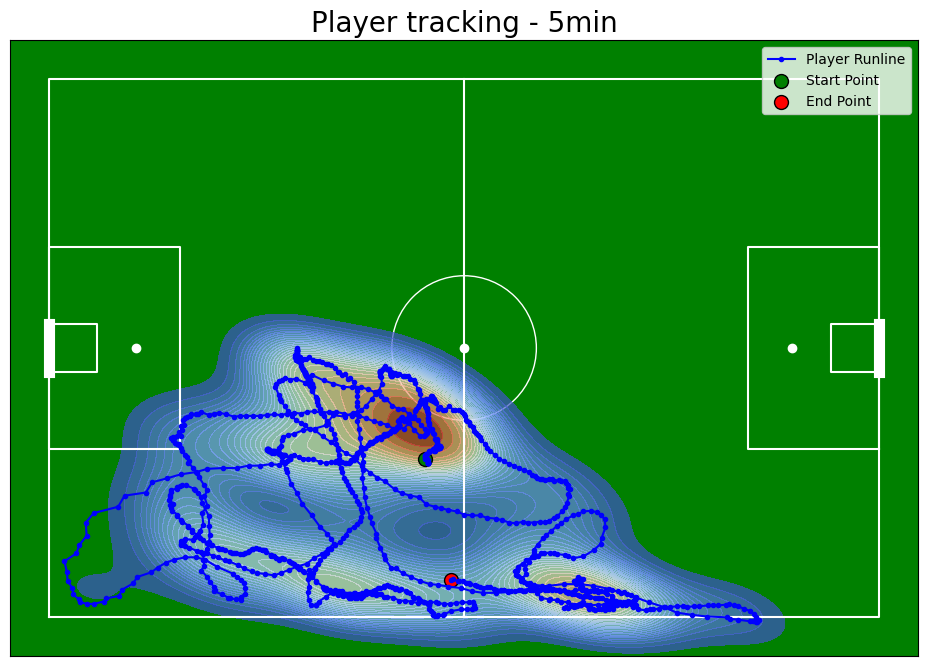

In [20]:
create_pitch(player_61_xy)

Add convex hull of player 61

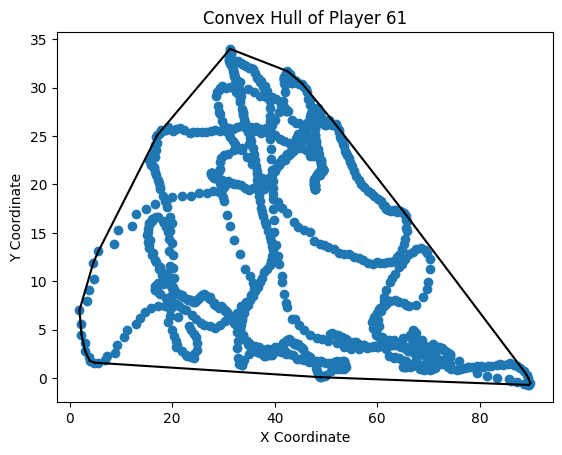

In [21]:
points = player_61_xy[['x', 'y']].values
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Convex Hull of Player 61')
plt.show()

Now we save the tracking data of team 0 in the variable `players_role_0`

In [22]:
players_role_0 = data[data["role"] == 0]
players_role_0.head(10)

frame_number  track_id  role  xworld  yworld   IoU
0              0        61     0    47.6    48.1  0.00
2              0        63     0    46.3    35.2  0.00
8              0        69     0    55.6    36.8  0.01
13             0        74     0    80.3    38.9  0.00
14             0        75     0    62.4    36.4  0.00
15             0        76     0    78.6    53.1  0.00
19             0        80     0    75.7    31.1  0.09
20             0        81     0    71.5    28.7  0.00
22             0        83     0    53.7    18.7  0.00
24             0        85     0    56.8    25.8  0.01

draw all convex hulls from each player of team 0, which gives us a raw assumptions what role/formation they play

C:\Users\sbart\AppData\Local\Temp\ipykernel_15828\1764362565.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))
C:\Users\sbart\AppData\Local\Temp\ipykernel_15828\1764362565.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best", title="Players")


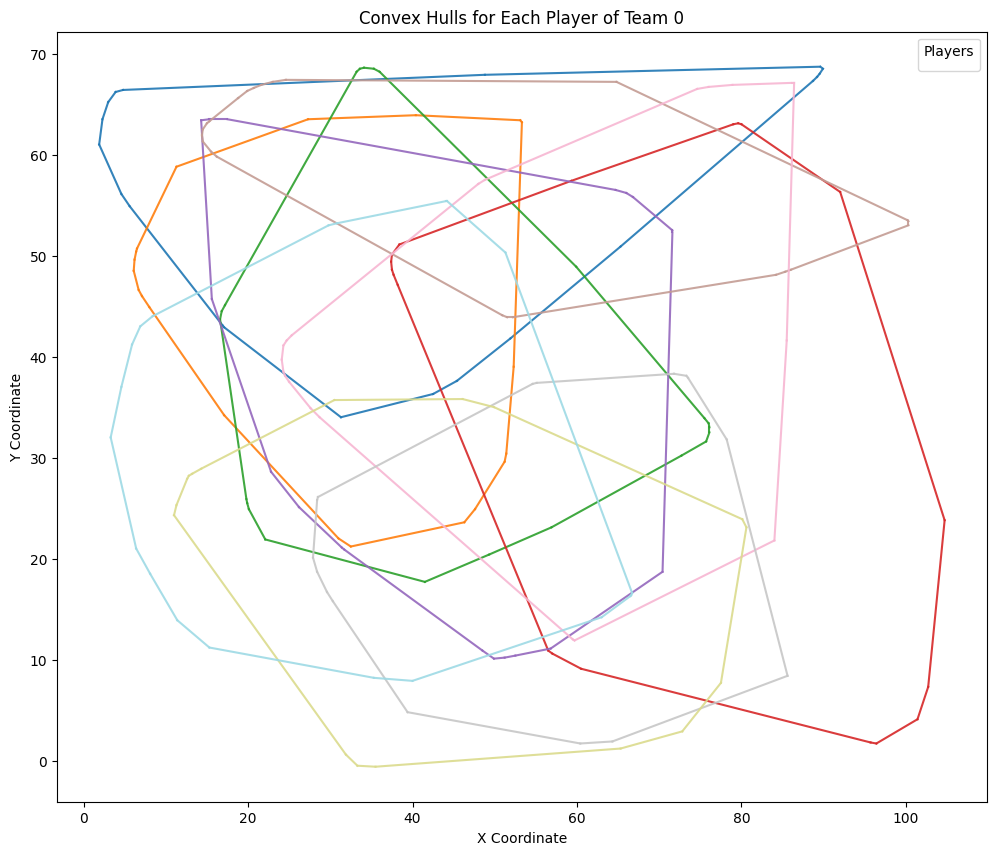

In [23]:
plt.figure(figsize=(12, 10))
color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))

for i, player_id in enumerate(players_role_0['track_id'].unique()):
    player_data = players_role_0[players_role_0['track_id'] == player_id]
    points = player_data[['xworld', 'yworld']].values  
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], '-', color=color_map(i), alpha=0.9)
    
plt.title('Convex Hulls for Each Player of Team 0')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(loc="best", title="Players")
plt.show()


# Role discovery using minimum entropy data partitions
according to Alina Bialkowski, Patrick Lucey et al. 2014. Large-scale analysis of soccer matches using spatiotemporal
tracking data. In IEEE International Conference on Data Mining

To identify specific role clusters for each player, we process the tracking data using K-Means clustering and the Hungarian algorithm (linear sum assignment). The process begins by normalizing player positions and initializing roles with K-Means clustering. Subsequently, roles are iteratively refined by minimizing a cost matrix derived from Gaussian probability distributions for each role. As the roles converge, Gaussian parameters are updated to improve accuracy. The process is complemented by visualizations that depict the progression and final structure of the role clusters.

## Normalize the tracking data

In [24]:
def normalize_tracking_data(df):
    df[['xworld_norm', 'yworld_norm']] = df.groupby('frame_number')[['xworld', 'yworld']].transform(
        lambda x: x - x.mean()
    )
    return df

## Assign initial specialized roles using K-Means

In [25]:
def initialize_roles_with_kmeans(df, n_roles=10): # n_roles = 10 bc there are 10 outfield players in a team
    kmeans = KMeans(n_clusters=n_roles, init='k-means++', random_state=42)
    normalized_positions = df[['xworld_norm', 'yworld_norm']].values
    df['specialized_role'] = kmeans.fit_predict(normalized_positions)
    initial_means = kmeans.cluster_centers_
    return df, initial_means

## Create a cost matrix and use Hungarian algorithm
Compute cost matrix based on log probabilities with separation bias

In [26]:
# PDF's stands for Probability Density Functions --> zu deutsch "Wahrscheinlichkeitsdichtefunktion"
def compute_cost_matrix(positions, role_pdfs, separation_bias=1.0): # separation_bias is a hyperparameter which influences the cost matrix, a higher value means a higher cost for players being close to each other
    n_positions = len(positions) # len of outer array, bc input is a 2D array
    n_roles = len(role_pdfs)
    cost_matrix = np.zeros((n_positions, n_roles)) # build the raw cost matrix

    for i, pos in enumerate(positions):
        for j, pdf in enumerate(role_pdfs):
            # Negative log-probability for cost, with a small separation bias
            cost_matrix[i, j] = -np.log(pdf.pdf(pos) + 1e-8) + separation_bias * np.linalg.norm(pos - pdf.mean)

    return cost_matrix
 

## Iterative role updates

In [27]:
def update_roles(df, initial_means, separation_bias=6.0, cov_decay_factor=0.01):
    unique_roles = np.unique(df['specialized_role']) # array of unique roles [0, ..., 9]

    # Initialize role PDFs with a large covariance in a dictionary
    role_pdfs = {
        role: multivariate_normal( # Multivariate normal distribution
            mean=initial_means[role], cov=np.eye(2) * 20
        ) for role in unique_roles
    }
 
    colors = [plt.cm.tab10(i % 10) for i in range(len(unique_roles))]

    max_iterations = 20
    iteration = 0
    converged = False
    x = 0

    # Iteratively assign roles and refine PDFs
    while not converged and iteration < max_iterations:
        prev_assignments = df['specialized_role'].copy() # copy the specialized roles from the previous iteration
        new_role_positions = {role: [] for role in unique_roles} # creates a dictionary with empty lists for each role
        
        for _, frame_data in df.groupby('frame_number'): # interate over each frame-group
            positions = frame_data[['xworld_norm', 'yworld_norm']].values # 2D-array of positions [[x1, y1], [x2, y2], ...]
            cost_matrix = compute_cost_matrix(positions, [role_pdfs[role] for role in unique_roles], separation_bias) 
            row_ind, col_ind = linear_sum_assignment(cost_matrix) # Hungarian algorithm
            df.loc[frame_data.index, 'specialized_role'] = [unique_roles[j] for j in col_ind]  

            for i, j in zip(row_ind, col_ind):
                new_role_positions[unique_roles[j]].append(positions[i]) # append the position to the corresponding role

        for role, positions in new_role_positions.items():
            if positions:
                positions = np.array(positions)
                mean = positions.mean(axis=0)
                cov_decay = max(cov_decay_factor, 10 / (iteration + 1))
                cov = np.cov(positions.T) + np.eye(2) * cov_decay
                role_pdfs[role] = multivariate_normal(mean=mean, cov=cov)

        iteration += 1
        converged = np.array_equal(prev_assignments.values, df['specialized_role'].values)

        plt.figure(figsize=(12, 8))
        x, y = np.mgrid[-30:30:.1, -30:30:.1]
        pos = np.dstack((x, y))
        for role, pdf in role_pdfs.items():
            plt.contour(x, y, pdf.pdf(pos), levels=5, colors=[colors[role]])
        plt.title(f'Role Distributions (Iteration {iteration})')
        plt.xlabel('X-World Normalized')
        plt.ylabel('Y-World Normalized')
        plt.grid()
        plt.show()

    #print("Final iteration:", iteration)
    return df, role_pdfs


Now we apply the function to our dataset (team 0), and plot each iterations until convergence

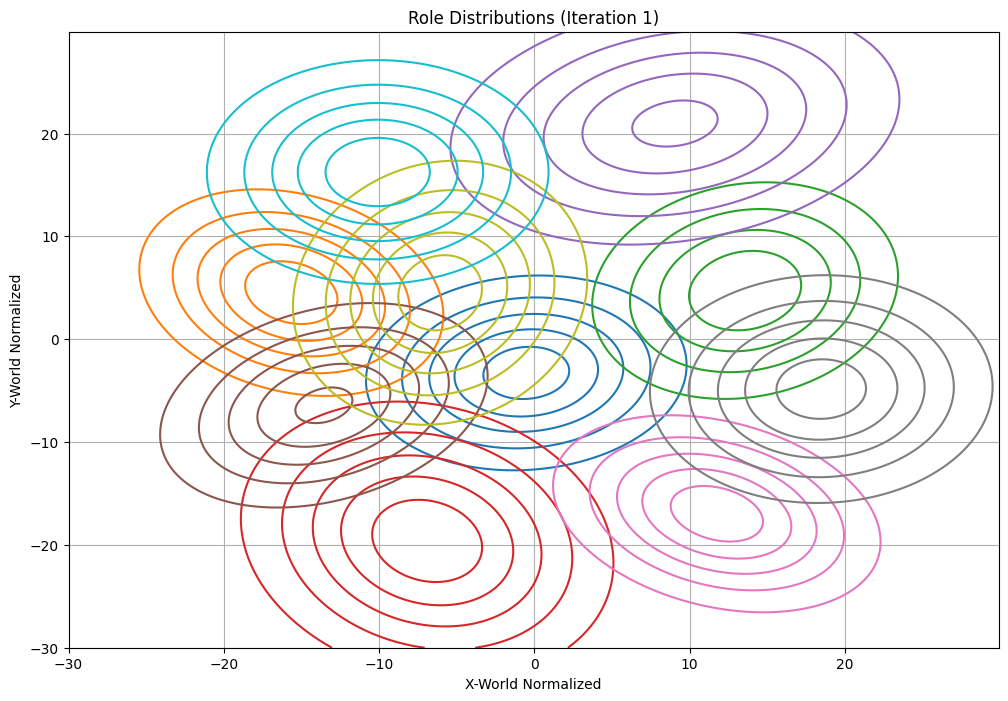

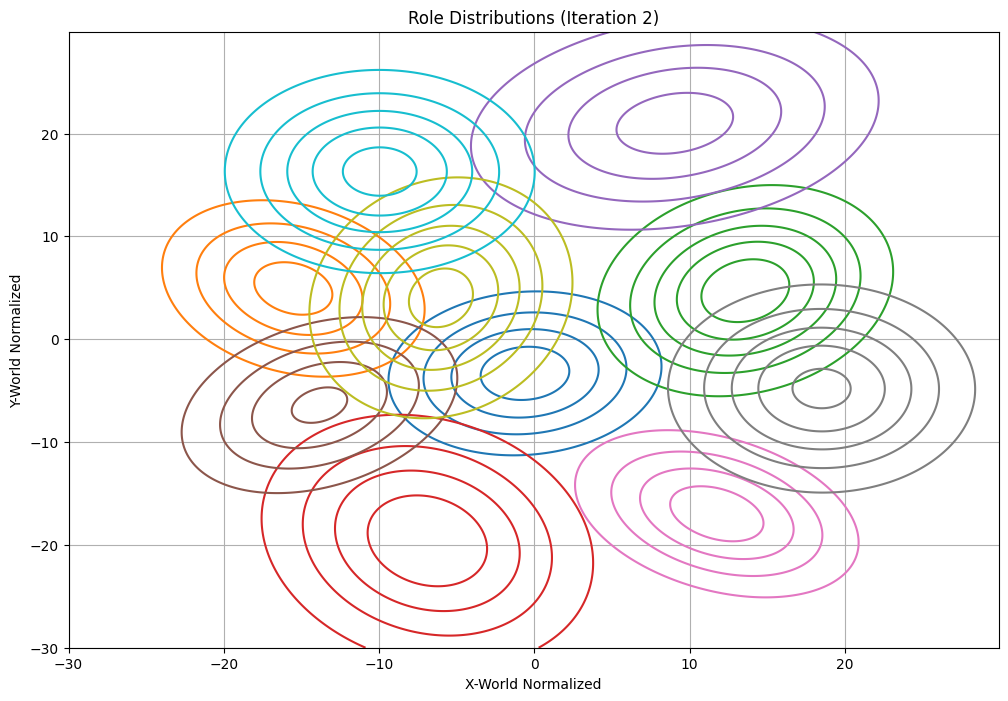

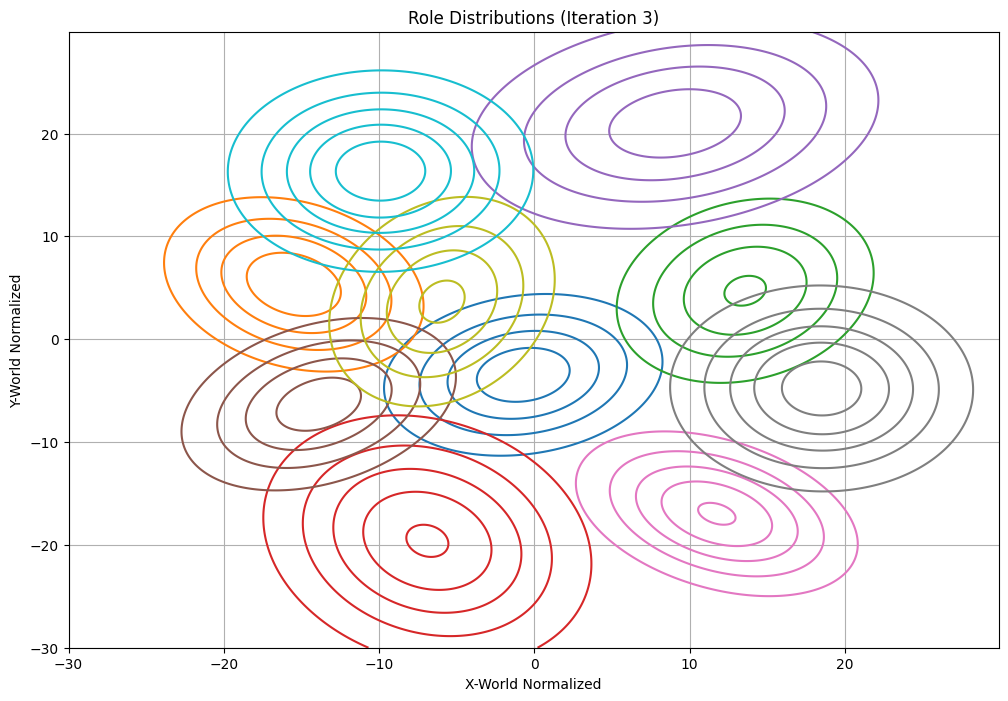

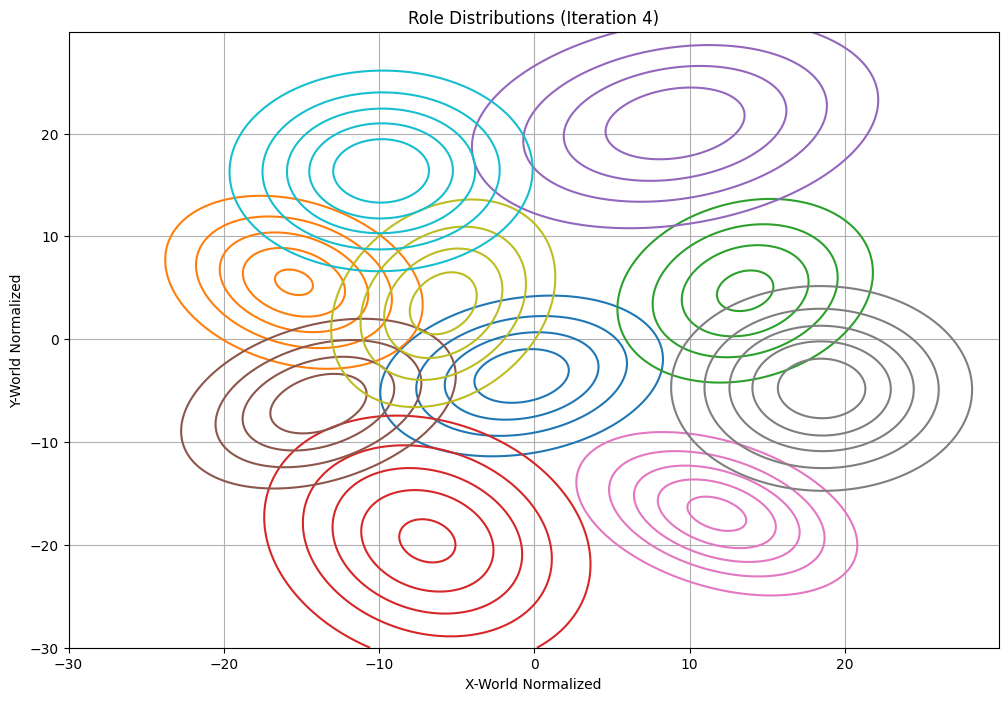

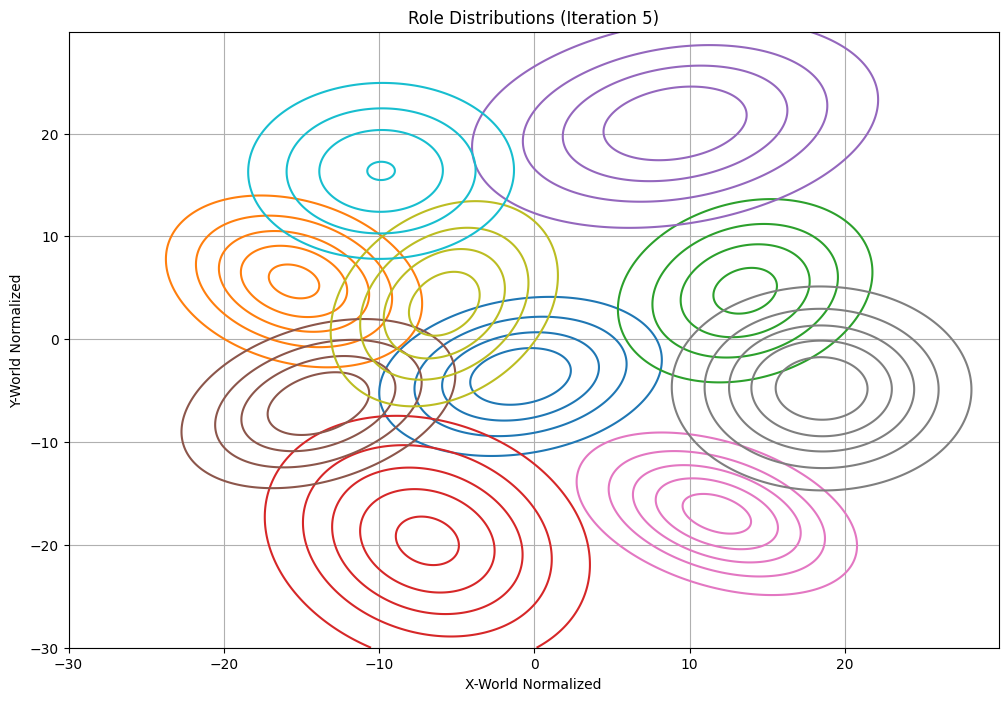

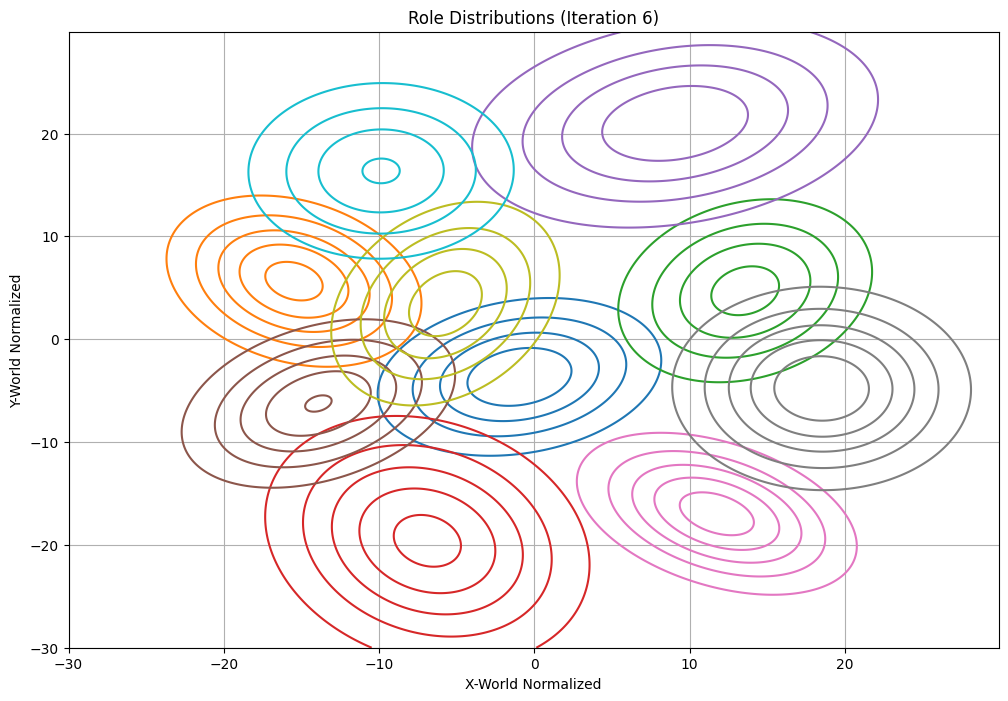

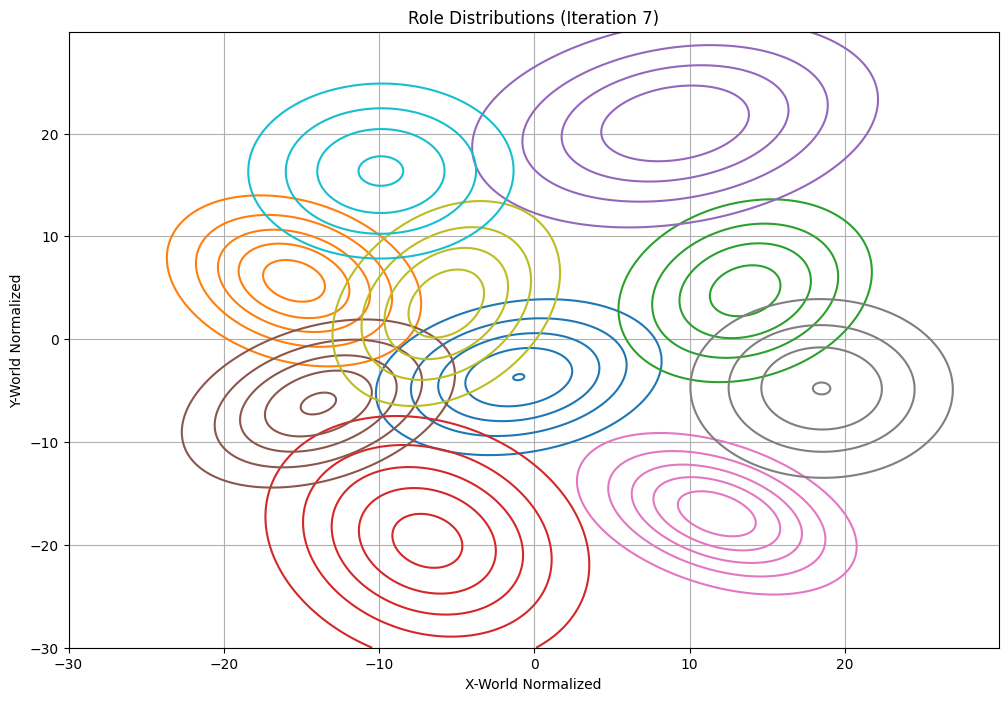

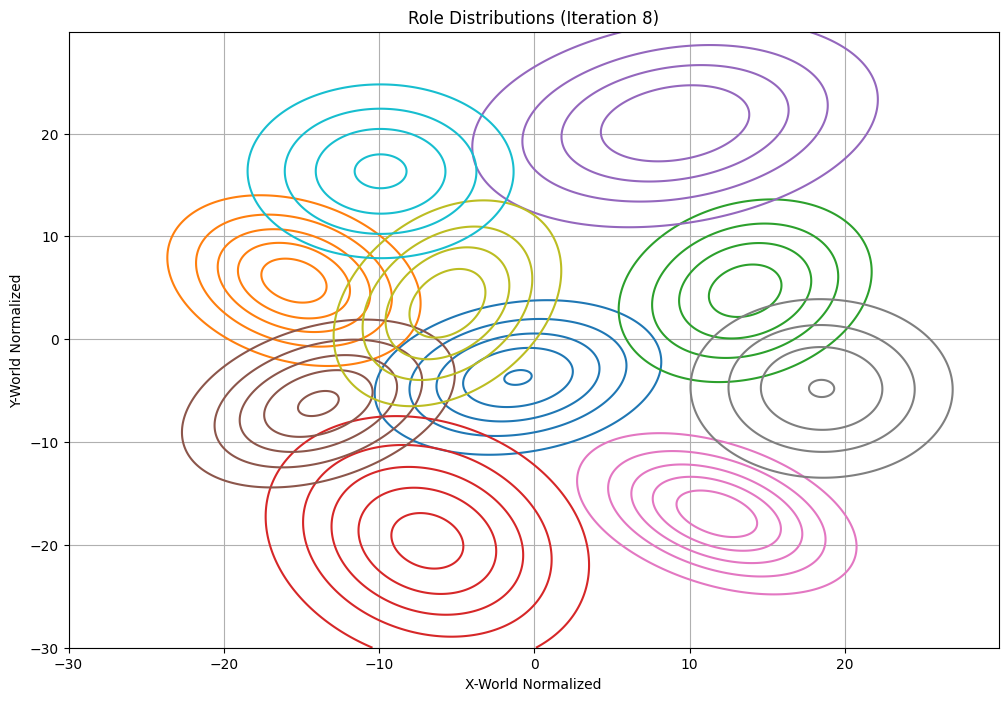

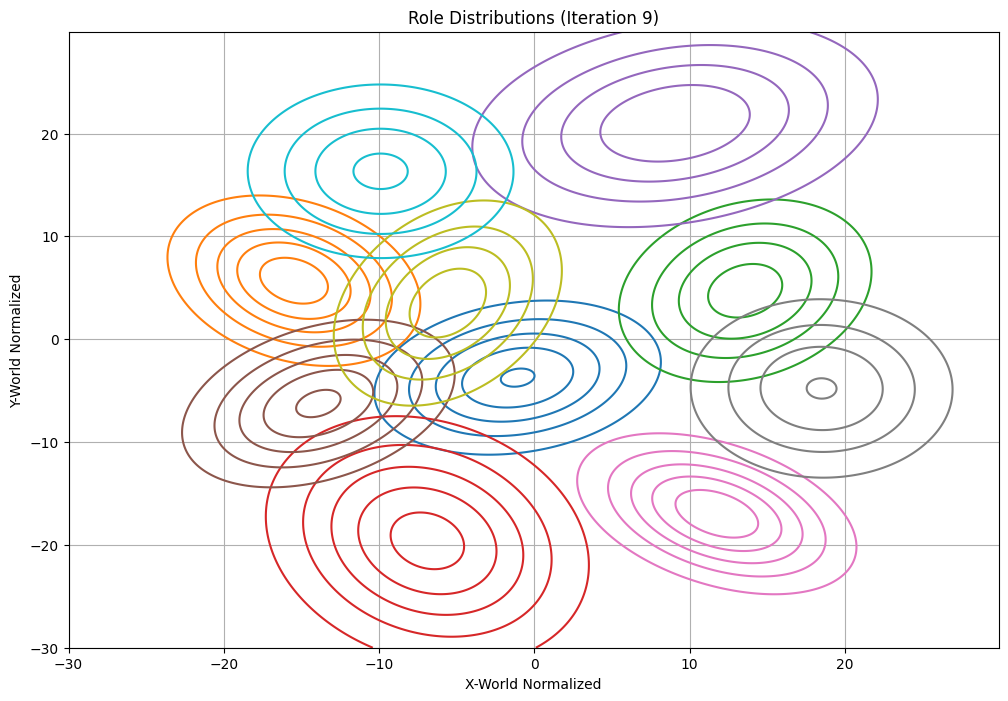

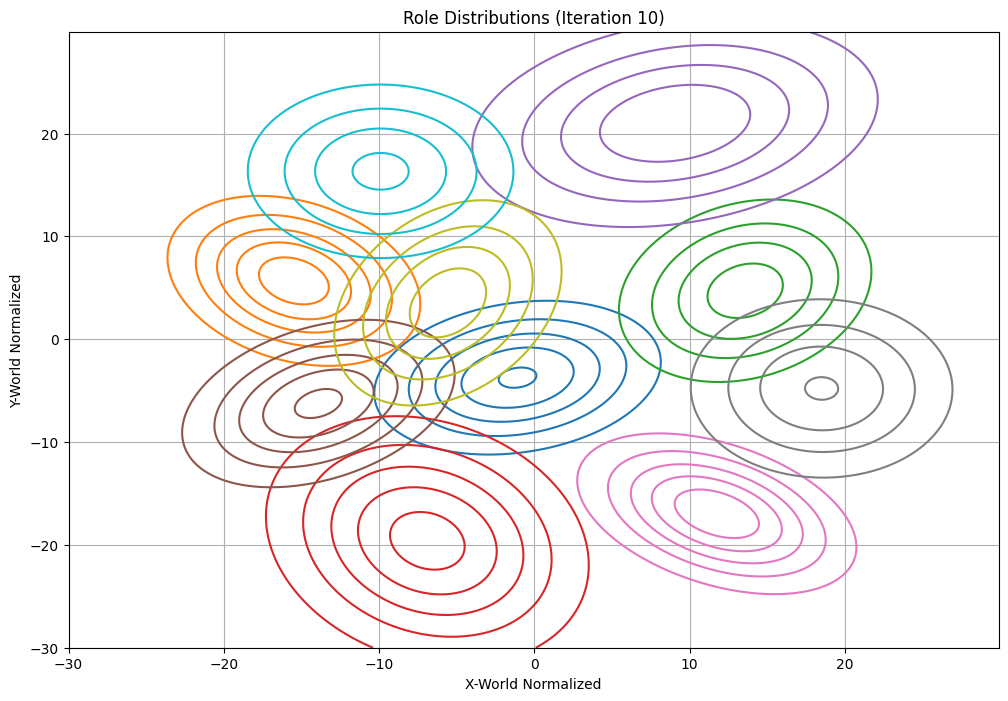

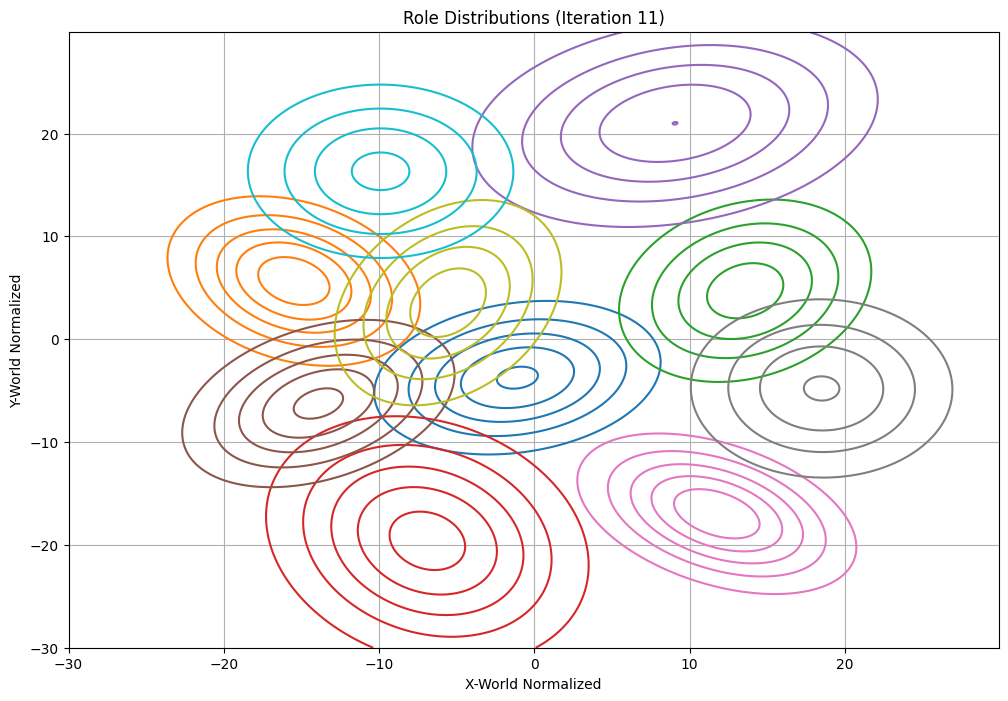

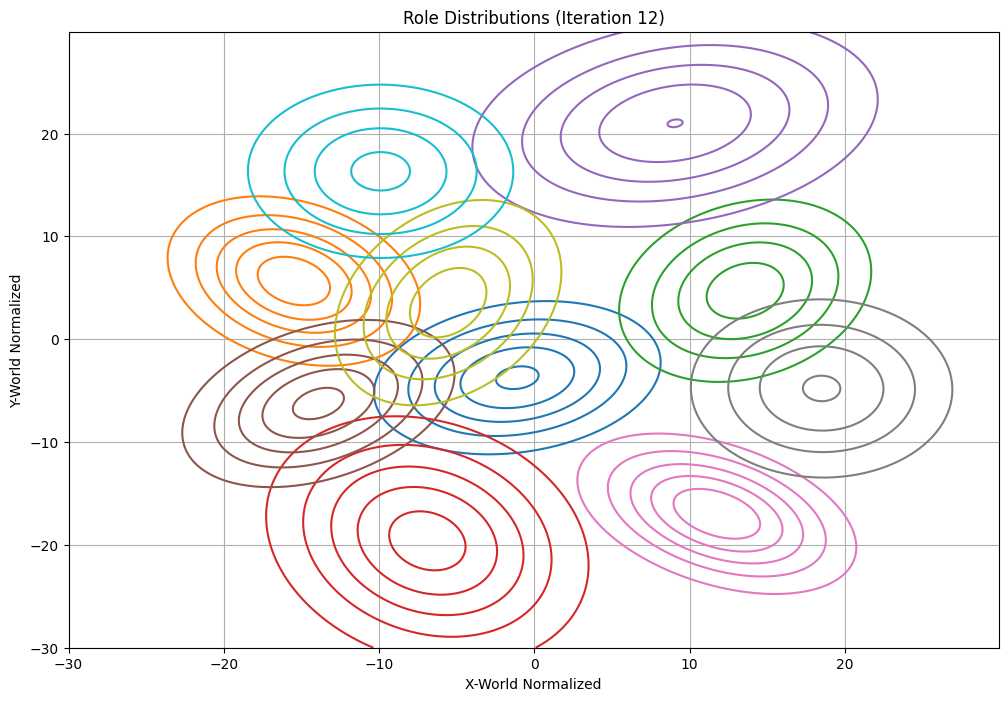

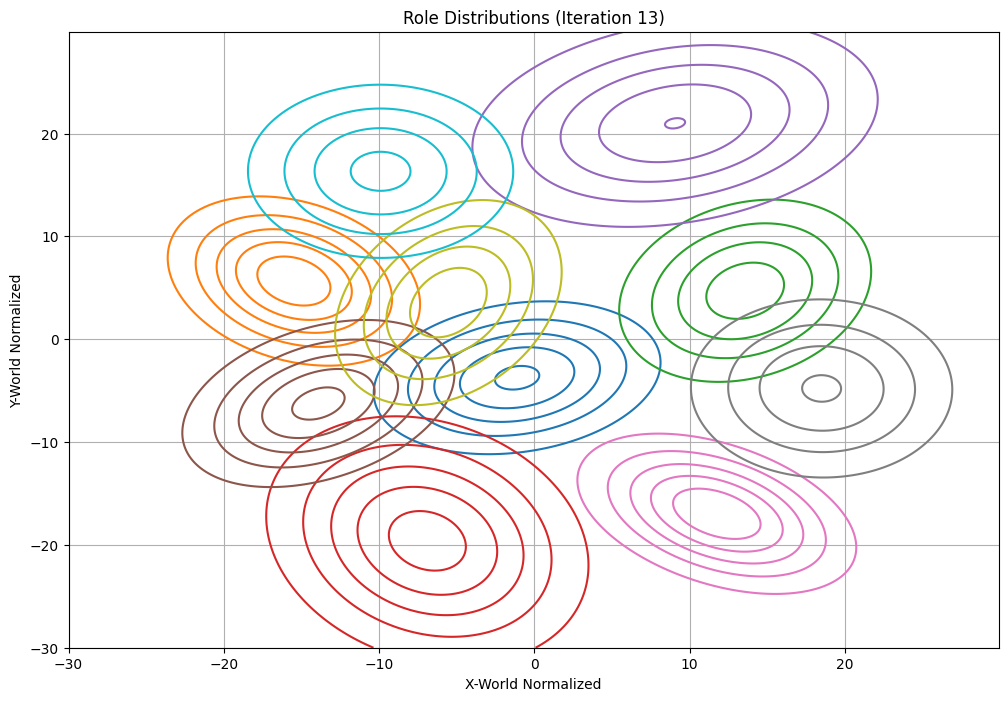

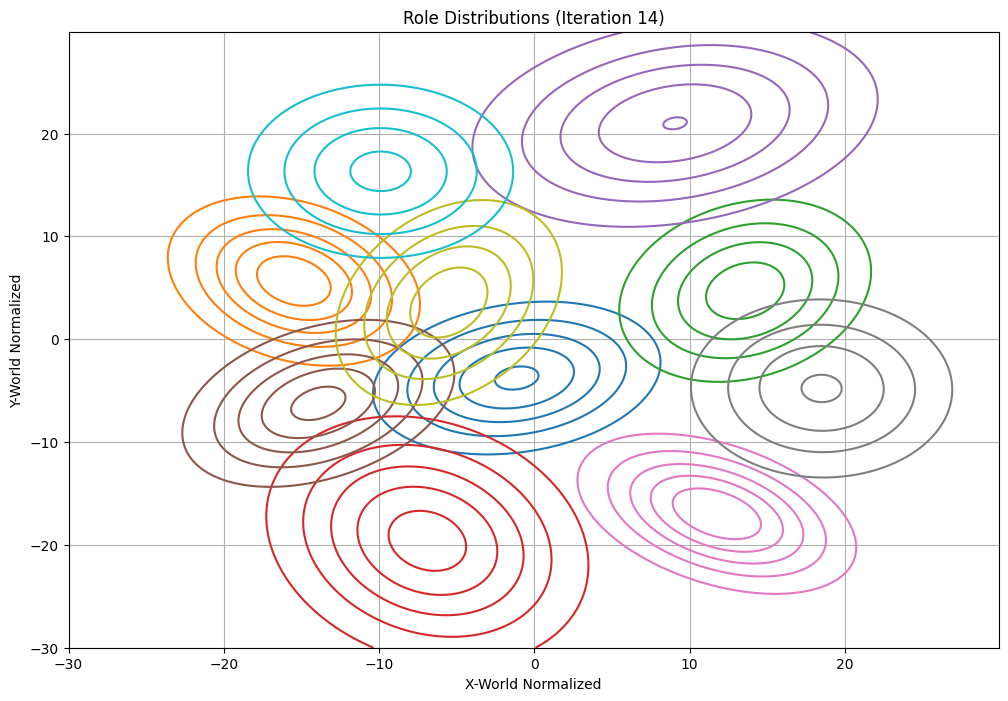

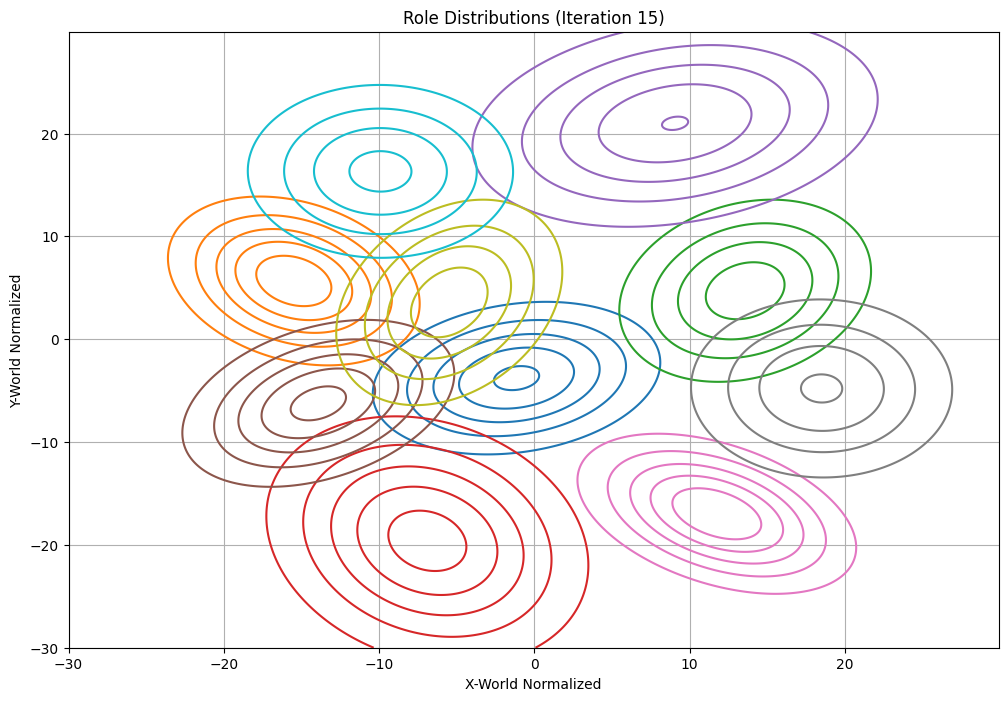

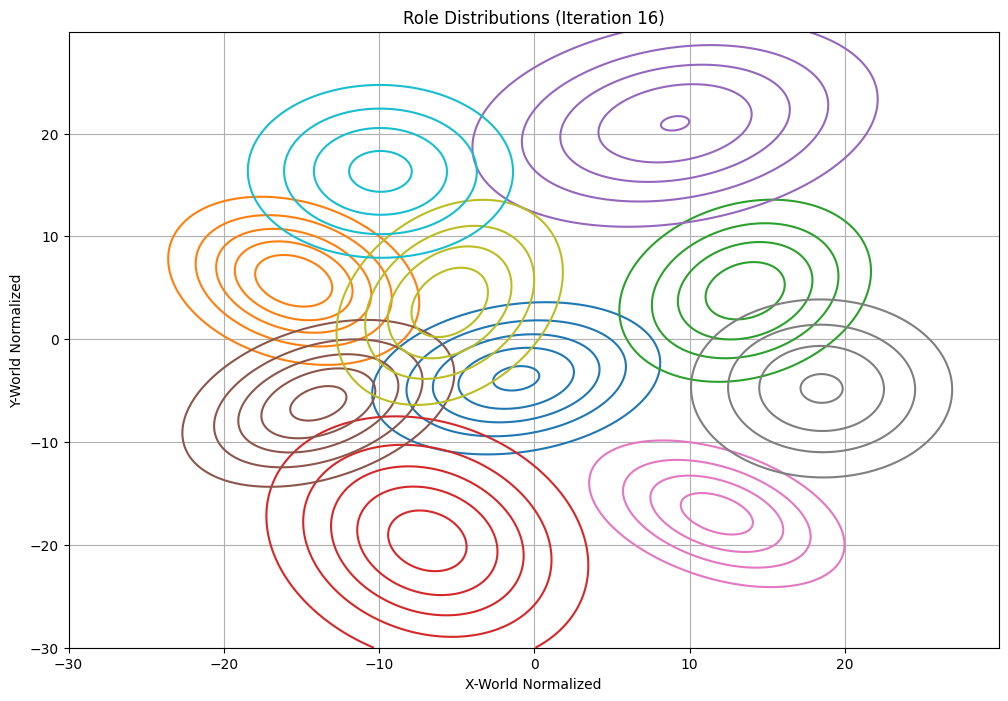

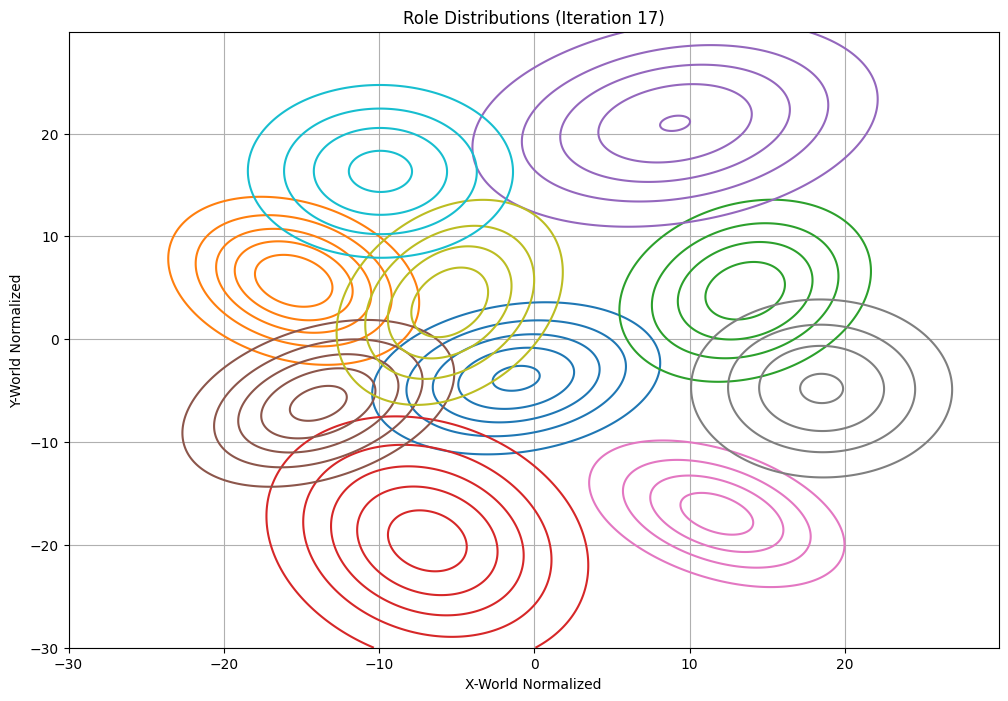

In [28]:
players_role_0 = normalize_tracking_data(players_role_0)
n_roles = 10  
players_role_0, initial_means = initialize_roles_with_kmeans(players_role_0, n_roles)
# Iteratively assign roles and refine PDFs
players_role_0, role_pdfs = update_roles(players_role_0, initial_means, separation_bias=20.0)

In the next plot, the tracking points which is associated cluster is displayed

C:\Users\sbart\AppData\Local\Temp\ipykernel_15828\4046912697.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(roles))


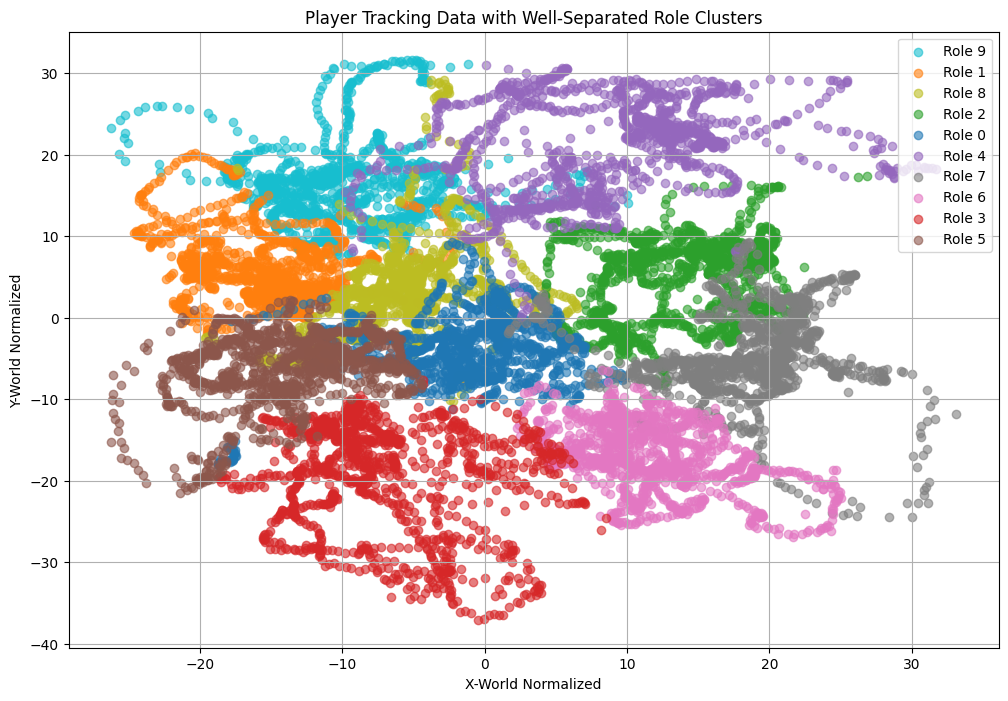

In [29]:
# Visualize final results
def plot_tracking_data(df):
    plt.figure(figsize=(12, 8))
    roles = df['specialized_role'].unique()
    colors = plt.cm.get_cmap("tab10", len(roles))

    for role in roles:
        role_data = df[df['specialized_role'] == role]
        plt.scatter(role_data['xworld_norm'], role_data['yworld_norm'], label=f'Role {role}', alpha=0.6, color=colors(role))

    plt.title('Player Tracking Data with Well-Separated Role Clusters')
    plt.xlabel('X-World Normalized')
    plt.ylabel('Y-World Normalized')
    plt.legend()
    plt.grid()
    plt.show()
# Plot the final tracking data
plot_tracking_data(players_role_0)

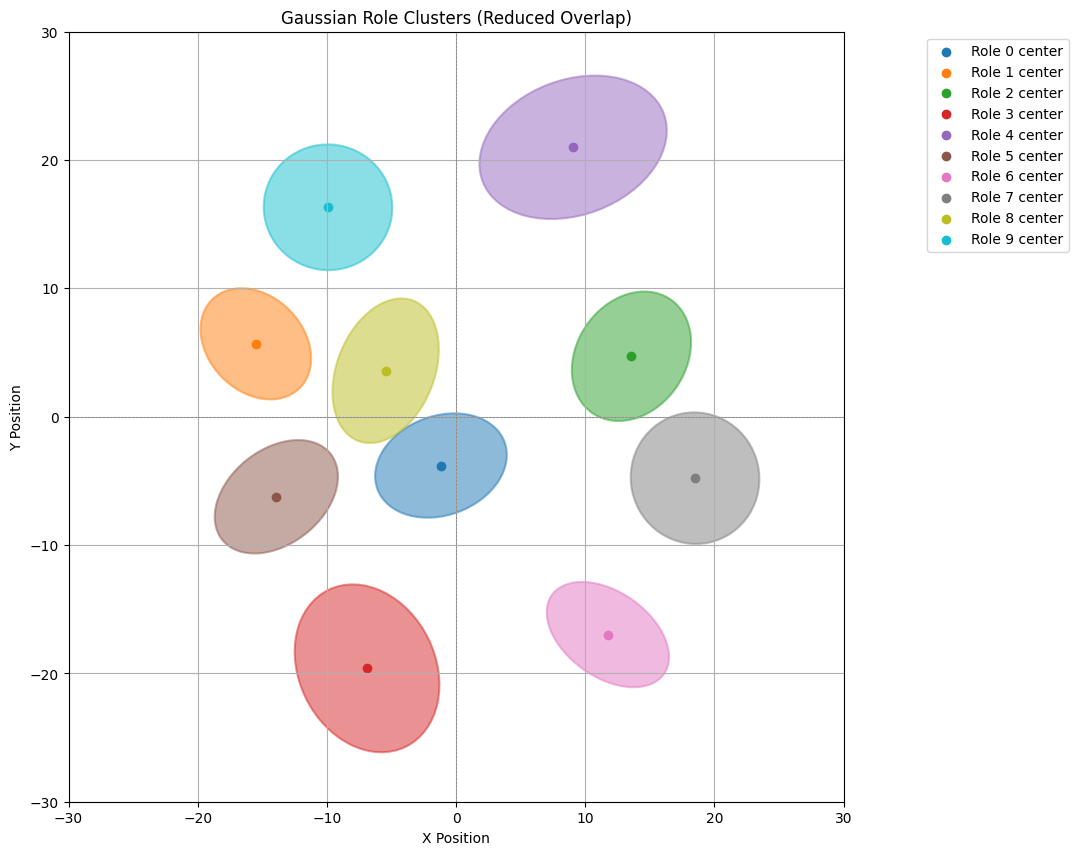

In [30]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

# Function to plot Gaussian ellipses with transparency
def plot_gaussian_ellipse(mean, cov, ax, label, color, alpha=0.5):
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * np.sqrt(eigvals)
    ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=alpha, lw=1.5)
    ax.add_patch(ellipse)
    ax.scatter(mean[0], mean[1], color=color, label=f'{label} center')

# Plot the updated roles
fig, ax = plt.subplots(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(role_pdfs)))

for role, pdf in role_pdfs.items():
    mean = pdf.mean
    cov = pdf.cov
    plot_gaussian_ellipse(mean, cov, ax, label=f"Role {role}", color=colors[role])

# Formatting plot
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Gaussian Role Clusters (Reduced Overlap)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
plt.grid(True)
plt.show()


In [31]:
pl61 = players_role_0[players_role_0["track_id"] == 61]
pl61["specialized_role"].value_counts()

specialized_role
9    914
4    234
8     61
1     31
2      1
Name: count, dtype: int64

In [32]:
pl61.shape

(1241, 9)

## get role switch per player(track_id)

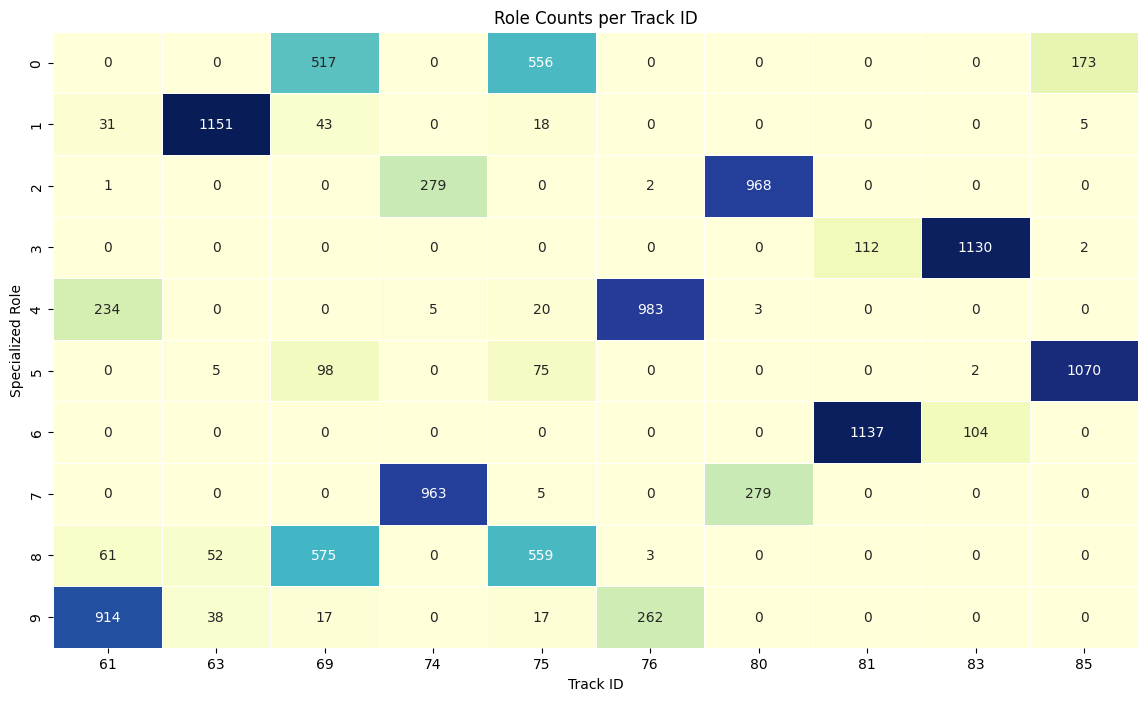

In [33]:
role_counts_per_track_id = {}
unique_track_ids = players_role_0['track_id'].unique()

for track_id in unique_track_ids:
    track_data = players_role_0[players_role_0['track_id'] == track_id]
    role_counts = track_data['specialized_role'].value_counts().sort_index()
    role_counts = role_counts.reindex(range(10), fill_value=0)
    role_counts_df = pd.DataFrame({'specialized_role': range(10), 'count': role_counts.values})
    role_counts_per_track_id[track_id] = role_counts_df
    role_counts_matrix = pd.DataFrame(index=range(10), columns=unique_track_ids)

    for track_id, role_counts_df in role_counts_per_track_id.items():
        role_counts_matrix[track_id] = role_counts_df['count'].values

plt.figure(figsize=(14, 8))
sns.heatmap(role_counts_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=.5)
plt.title('Role Counts per Track ID')
plt.xlabel('Track ID')
plt.ylabel('Specialized Role')
plt.show()

In [34]:
players_role_0.head(10)

frame_number  track_id  role  xworld  yworld   IoU  xworld_norm  \
0              0        61     0    47.6    48.1  0.00       -15.25   
2              0        63     0    46.3    35.2  0.00       -16.55   
8              0        69     0    55.6    36.8  0.01        -7.25   
13             0        74     0    80.3    38.9  0.00        17.45   
14             0        75     0    62.4    36.4  0.00        -0.45   
15             0        76     0    78.6    53.1  0.00        15.75   
19             0        80     0    75.7    31.1  0.09        12.85   
20             0        81     0    71.5    28.7  0.00         8.65   
22             0        83     0    53.7    18.7  0.00        -9.15   
24             0        85     0    56.8    25.8  0.01        -6.05   

    yworld_norm  specialized_role  
0         12.82                 9  
2         -0.08                 1  
8          1.52                 8  
13         3.62                 2  
14         1.12                 0  
15        17.82                 4  
19        -4.18                 7  
20        -6.58                 6  
22       -16.58                 3  
24        -9.48                 5

In [35]:
for role, pdfs in role_pdfs.items():
    print(f"Role {role} Mean={pdfs.mean}, Covariance={pdfs.cov}")

Role 0 Mean=[-1.16581327 -3.80246388], Covariance=[[26.00698793  4.21113934]
 [ 4.21113934 16.52972489]]
Role 1 Mean=[-15.49641471   5.67929754], Covariance=[[18.35348883 -4.85736982]
 [-4.85736982 18.76026549]]
Role 2 Mean=[13.58175733  4.71217511], Covariance=[[21.30656853  4.99211293]
 [ 4.99211293 25.44109074]]
Role 3 Mean=[ -6.88823955 -19.60585298], Covariance=[[31.3660854  -7.23445564]
 [-7.23445564 42.767203  ]]
Role 4 Mean=[ 9.06615529 20.99414279], Covariance=[[52.62267059  9.4290851 ]
 [ 9.4290851  31.24481784]]
Role 5 Mean=[-13.91104267  -6.23670489], Covariance=[[22.76062832  7.49353091]
 [ 7.49353091 19.53352977]]
Role 6 Mean=[ 11.75603635 -16.97542573], Covariance=[[22.40619025 -8.21352383]
 [-8.21352383 16.8336083 ]]
Role 7 Mean=[18.50496035 -4.78818765], Covariance=[[24.80063182 -0.33247096]
 [-0.33247096 26.26660875]]
Role 8 Mean=[-5.44896267  3.58257511], Covariance=[[16.93256816  6.83281804]
 [ 6.83281804 31.71834044]]
Role 9 Mean=[-9.91056179 16.31962874], Covarian

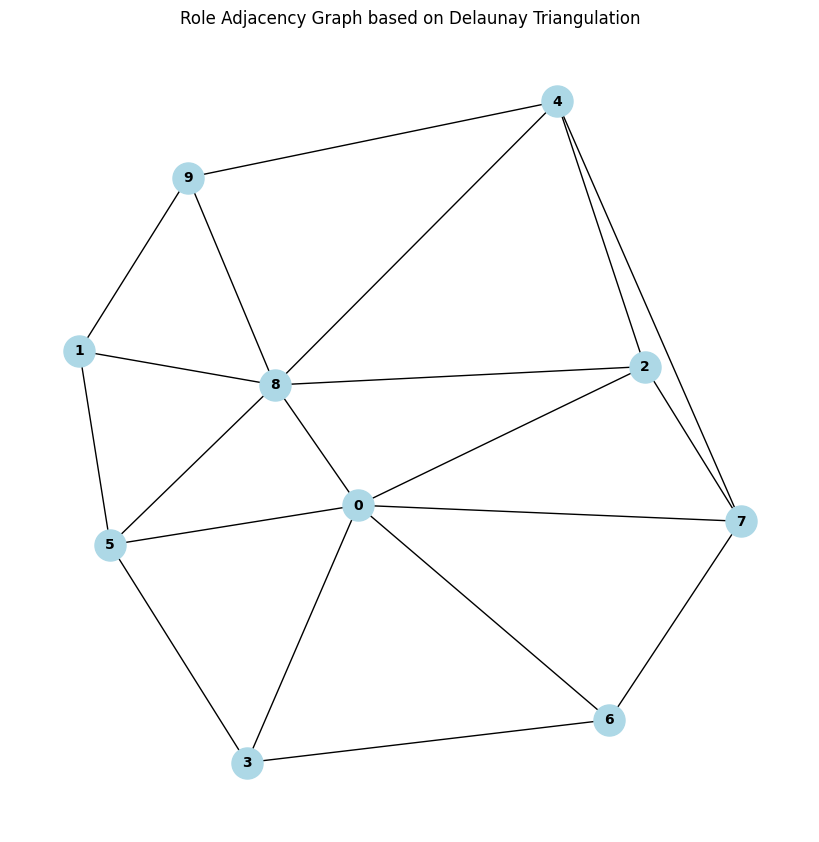

In [36]:
from scipy.spatial import Delaunay
import networkx as nx

# Extract the mean positions of each role
role_means = np.array([pdf.mean for pdf in role_pdfs.values()])

# Perform Delaunay triangulation
tri = Delaunay(role_means)

# Create adjacency matrix
adj_matrix = np.zeros((n_roles, n_roles))

# Populate adjacency matrix based on Delaunay simplices
for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            adj_matrix[simplex[i], simplex[j]] = 1
            adj_matrix[simplex[j], simplex[i]] = 1

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Plot the graph
plt.figure(figsize=(8, 8))
pos = {i: role_means[i] for i in range(n_roles)}
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title('Role Adjacency Graph based on Delaunay Triangulation')
plt.show()

<Axes: >

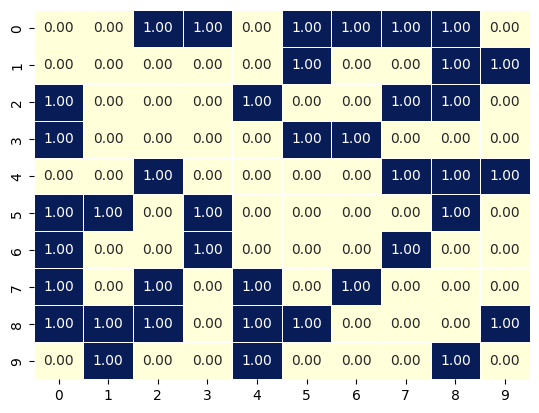

In [37]:
adj_m = pd.DataFrame(adj_matrix)
sns.heatmap(adj_m, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5)

In [38]:
import scipy.spatial
import networkx as nx

# Beispiel: Punkte
points = [(0, 0), (1, 0), (0, 1), (1, 1)]

# Delaunay-Triangulation
tri = scipy.spatial.Delaunay(points)

# Graph erstellen
G1 = nx.Graph()
for simplex in tri.simplices:  # Triangulation besteht aus Dreiecken
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            G1.add_edge(simplex[i], simplex[j])

# Zweiter Punktesatz
points2 = [(1, 0), (0, 0), (1, 0), (1, 1)]  # Kleine Änderung
tri2 = scipy.spatial.Delaunay(points2)

# Zweiter Graph
G2 = nx.Graph()
for simplex in tri2.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            G2.add_edge(simplex[i], simplex[j])
# GED berechnen
ged = nx.graph_edit_distance(G1, G2)
print(f"Graph Edit Distance: {ged}")


Graph Edit Distance: 3.0


In [39]:
edges1 = set(G1.edges())
edges2 = set(G2.edges())

# Jaccard-Distanz
intersection = len(edges1 & edges2)
union = len(edges1 | edges2)
jaccard_distance = 1 - intersection / union
print(f"Jaccard Distance: {jaccard_distance}")


Jaccard Distance: 0.6666666666666667


In [40]:
import numpy as np

# Adjazenzmatrizen
A1 = nx.adjacency_matrix(G1).toarray()
A2 = nx.adjacency_matrix(G2).toarray()

# Anpassung der Matrizenform (falls Knoten unterschiedlich)
size = max(A1.shape[0], A2.shape[0])
A1_padded = np.zeros((size, size))
A2_padded = np.zeros((size, size))
A1_padded[:A1.shape[0], :A1.shape[1]] = A1
A2_padded[:A2.shape[0], :A2.shape[1]] = A2

# Frobenius-Norm der Differenz
frobenius_distance = np.linalg.norm(A1_padded - A2_padded, ord='fro')
print(f"Frobenius Distance: {frobenius_distance}")


Frobenius Distance: 2.0


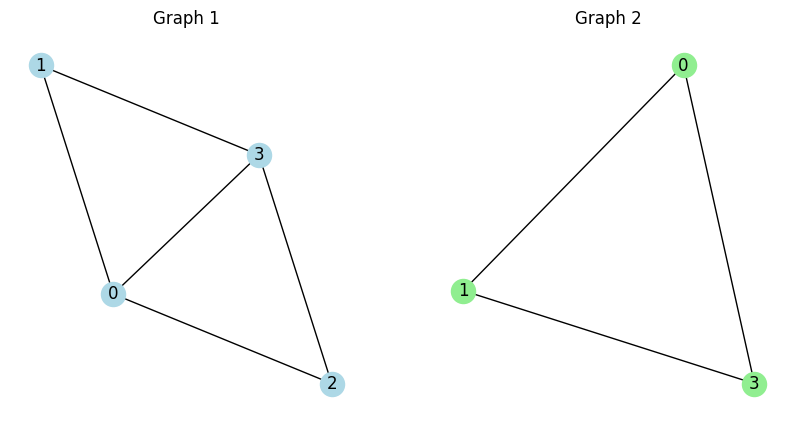

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(121)
nx.draw(G1, with_labels=True, node_color='lightblue')
plt.title("Graph 1")
plt.subplot(122)
nx.draw(G2, with_labels=True, node_color='lightgreen')
plt.title("Graph 2")
plt.show()


# All files
The entire dataset consists of 512897 datapoints.

In [42]:
file_paths = glob.glob('xy data/*.txt')
tracking_data = pd.concat((pd.read_csv(file, sep=",", header=None) for file in file_paths), ignore_index=True)
tracking_data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
tracking_data.info

<bound method DataFrame.info of         frame_number  track_id  role    xbox   ybox     w      h  xworld  \
0                  0       105     0   941.1  505.4  80.4  129.6    38.4   
1                  0        92     2   969.1  304.0  49.3   73.4    30.5   
2                  0        93     1   815.5  401.7  60.6   80.4    29.3   
3                  0        94     1  1536.3  206.7  37.9   70.7    45.5   
4                  0        95     1   866.6  288.7  33.0   47.8    19.2   
...              ...       ...   ...     ...    ...   ...    ...     ...   
512892          7494       508     0   893.7  451.8  30.9   52.0    24.0   
512893          7494       507     0  1285.6  360.8  25.4   38.6    32.9   
512894          7494       516     1  1114.7  382.6  21.3   33.8    24.5   
512895          7494       512     0  1039.8  401.4  26.8   40.0    23.8   
512896          7494       528     1  1400.6  327.9  15.5   24.4    32.8   

        yworld   IoU  
0         57.1  0.00  
1        

In [43]:
tracking_data.shape

(512897, 10)

In [44]:
tracking_data["track_id"].nunique()

464

In [45]:
tracking_data["role"].value_counts()

role
 1      221990
 0      221469
 2       27990
 4       19862
 3       19752
 155       507
 166       506
 400       361
 396       345
-1         115
Name: count, dtype: int64

At fis2 and stv2 we have unclear roles

In [46]:
tracking_data[tracking_data["role"] == 400]

frame_number  track_id  role   xbox   ybox      w      h  xworld  \
391508           400       400   400  400.0  400.0  400.0  400.0   400.0   
391528           400       400   400  400.0  400.0  400.0  400.0   400.0   
391548           400       400   400  400.0  400.0  400.0  400.0   400.0   
391570           400       400   400  400.0  400.0  400.0  400.0   400.0   
391591           400       400   400  400.0  400.0  400.0  400.0   400.0   
...              ...       ...   ...    ...    ...    ...    ...     ...   
399607           400       400   400  400.0  400.0  400.0  400.0   400.0   
399630           400       400   400  400.0  400.0  400.0  400.0   400.0   
399652           400       400   400  400.0  400.0  400.0  400.0   400.0   
399674           400       400   400  400.0  400.0  400.0  400.0   400.0   
399697           400       400   400  400.0  400.0  400.0  400.0   400.0   

        yworld    IoU  
391508   400.0  400.0  
391528   400.0  400.0  
391548   400.0  400.0  
391570   400.0  400.0  
391591   400.0  400.0  
...        ...    ...  
399607   400.0  400.0  
399630   400.0  400.0  
399652   400.0  400.0  
399674   400.0  400.0  
399697   400.0  400.0  

[361 rows x 10 columns]